# Imports

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import re
import nltk
from nltk.corpus import stopwords
#import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# NLTK Downloads

In [33]:
nltk.download('stopwords')
print("NLTK stopwords downloaded.")

NLTK stopwords downloaded.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Predator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Text Cleaning Function

In [34]:
def cleanText(textCol):
    corpus = []
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not') # Keep 'not' as it's important for sentiment
    stop_words_set = set(all_stopwords)
    
    for text in textCol:
        # 'text' is already a string, no need for str(X[i])
        review = re.sub('[^a-zA-Z]', ' ', text)
        review = review.lower()
        review = review.split()
        
        # We do NOT stem. Deep learning models can learn from "running" vs "run"
        review = [word for word in review if not word in stop_words_set]
        review = ' '.join(review)
        corpus.append(review)
    
    return corpus

# Loading Data

In [35]:
def convert_score_to_sentiment(score):
    try:
        num_score = float(score)
        if num_score > 3:
            return 'positive'
        elif num_score < 3:
            return 'negative'
        else:
            return 'neutral'
    except ValueError:
        return 'neutral'

In [36]:
file_path = "datasets/traingset/*.csv"
# Get a list of all matching file paths
all_csv_files = glob.glob(file_path)

In [37]:
if not all_csv_files:
    print(f"No CSV files found at '{file_path}'. Please check the path.")
else:
    print(f"Found {len(all_csv_files)} files. Processing...")

Found 5 files. Processing...


In [38]:
# This list will hold all the individual, processed DataFrames
dataframes_list = []

In [39]:
for filepath in all_csv_files:
    try:
        df = pd.read_csv(filepath, encoding='latin1')
        if 'sentiment' in df.columns and 'text' in df.columns:
            temp_df = df[['text', 'sentiment']]
            print(temp_df.shape)
            dataframes_list.append(temp_df)
        
        elif 'score' in df.columns and 'text' in df.columns:
            df['sentiment'] = df['score'].apply(convert_score_to_sentiment)
            temp_df = df[['text', 'sentiment']]
            print(temp_df.shape)
            dataframes_list.append(temp_df)

        elif 'sentiment' in df.columns and 'review' in df.columns:
            df.rename(columns={'review': 'text'}, inplace=True)
            temp_df = df[['text', 'sentiment']]
            print(temp_df.shape)
            dataframes_list.append(temp_df)
            
        elif 'review' in df.columns and 'score' in df.columns:
            df.rename(columns={'review': 'text'}, inplace=True)
            df['sentiment'] = df['score'].apply(convert_score_to_sentiment)
            temp_df = df[['text', 'sentiment']]
            print(temp_df.shape)
            dataframes_list.append(temp_df)

        else:
            print(f"Warning: Skipping file '{filepath}'. "
                  "It doesn't have the required 'text' and 'sentiment'/'score' columns.")

    except Exception as e:
        print(f"Error processing file '{filepath}': {e}")

(50000, 2)
(568454, 2)
(4815, 2)
(27481, 2)
(74682, 2)


In [40]:
# --- 4. Combine All DataFrames ---
if dataframes_list:
    final_df = pd.concat(dataframes_list, ignore_index=True)
    print(final_df.shape)

    print("\nFinal DataFrame Head:")
    print(final_df.head())
    
    print("\nFinal DataFrame Info:")
    final_df.info()
    
    print("\nSentiment Value Counts:")
    print(final_df['sentiment'].value_counts())
    '''
    # Optional: Clean up any rows where 'text' might be missing
    final_df.dropna(subset=['text'], inplace=True)
    '''
    print(f"\nTotal rows after cleaning: {len(final_df)}")

    # Optional: Save to a new file
    # final_df.to_csv("combined_sentiments.csv", index=False)
    # print("Combined file saved as 'combined_sentiments.csv'")

else:
    print("No data was processed. Please check your files and path.")

(725432, 2)

Final DataFrame Head:
                                                text sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Final DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 725432 entries, 0 to 725431
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       723464 non-null  object
 1   sentiment  724151 non-null  object
dtypes: object(2)
memory usage: 11.1+ MB

Sentiment Value Counts:
sentiment
positive      499294
negative      138361
neutral        73506
irrelevant     12990
Name: count, dtype: int64

Total rows after cleaning: 725432


In [41]:
# Drop rows with missing values
final_df.dropna(subset=['sentiment', 'text'], inplace=True)
print(f"Data loaded and cleaned. Shape: {final_df.shape}")

Data loaded and cleaned. Shape: (723464, 2)


# Visualizing the Dataset


Bar chart saved as 'sentiment_distribution.png'


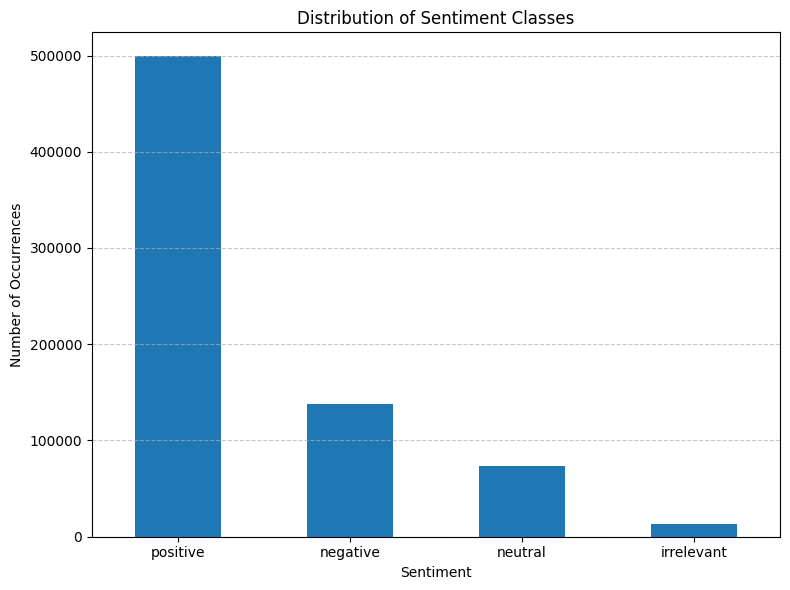

In [42]:
sentiment_counts = final_df['sentiment'].value_counts()
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=0)  # Keeps labels like 'positive' upright
plt.grid(axis='y', linestyle='--', alpha=0.7) # Adds a helpful grid
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
# 5. Save the plot to a file
plt.savefig('sentiment_distribution.png')
print("\nBar chart saved as 'sentiment_distribution.png'")

## Cleaning text

In [43]:
final_df['Cleaned_Text'] = cleanText(final_df['text'])

In [44]:
final_df.head()

,text,sentiment,Cleaned_Text
0,One of the other reviewers has mentioned that ...,positive,one reviewers mentioned watching oz episode ho...
1,A wonderful little production. <br /><br />The...,positive,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,positive,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,basically family little boy jake thinks zombie...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter mattei love time money visually stunnin...


In [45]:
final_df.shape

(723464, 3)

In [46]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(final_df['sentiment'])

In [47]:
# Then, one-hot encode for Keras
# e.g., 2 -> [0, 0, 1, 0]
y_one_hot = to_categorical(y_encoded)
num_classes = y_one_hot.shape[1] # This will be 4
print(f"Target variable 'y' has been one-hot encoded into {num_classes} classes.")

Target variable 'y' has been one-hot encoded into 4 classes.


In [48]:
# Print the array of class names
print(label_encoder.classes_)

['irrelevant' 'negative' 'neutral' 'positive']


# Splitting Dataset

In [49]:
# CRITICAL: We split the data BEFORE tokenizing to prevent "data leakage"
X_train_text, X_test_text, y_train, y_test = train_test_split(
    final_df['Cleaned_Text'], 
    y_one_hot, 
    test_size=0.20, 
    random_state=42, 
    stratify=y_encoded # Use the integer labels for stratification
)
print("Data split into training and testing sets.")

Data split into training and testing sets.


# Tokenizing and Padding

In [50]:
print("Tokenizing and padding text...")

# Define key parameters
VOCAB_SIZE = 10000  # How many unique words to keep
MAX_LEN = 100       # Max length of a tweet (in words)
EMBEDDING_DIM = 64  # Dimension of the word vectors

Tokenizing and padding text...


In [51]:
# Keras Tokenizer: learns a vocabulary from the text
# num_words: only keep the top 10,000 most frequent words
# oov_token: a special token for words that are "out of vocabulary"
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")

In [52]:
# Fit the tokenizer ONLY on the training text
tokenizer.fit_on_texts(X_train_text)

In [53]:
# Convert text to sequences of integers
train_sequences = tokenizer.texts_to_sequences(X_train_text)
test_sequences = tokenizer.texts_to_sequences(X_test_text)

In [54]:
# Pad sequences so they are all the same length (MAX_LEN)
# 'post' means padding with 0s at the end
train_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [55]:
print("Text tokenized and padded.")
print(f"Shape of training data: {train_padded.shape}")
print(f"Shape of test data: {test_padded.shape}")

Text tokenized and padded.
Shape of training data: (578771, 100)
Shape of test data: (144693, 100)


# Building Model

In [56]:
print("Building the LSTM model...")

model = Sequential()

# 1. Embedding Layer: Turns word integers into dense vectors (our 'word embeddings')
model.add(Embedding(
    input_dim=VOCAB_SIZE,       # The size of our vocabulary (10,000)
    output_dim=EMBEDDING_DIM,   # The size of the vector for each word (64)
    input_length=MAX_LEN        # The length of our sequences (100)
))

Building the LSTM model...


E:\Sentiment Analysis\DL\dl_env\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [57]:
# 2. SpatialDropout1D: Helps prevent overfitting by dropping entire words
model.add(SpatialDropout1D(0.2))

In [58]:
# 3. LSTM Layer: Reads the sequence of vectors and learns context
# Bidirectional means it reads the sequence both forwards and backwards
model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))

In [59]:
# 4. Dense Layer: A standard fully-connected layer for classification
model.add(Dense(64, activation='relu'))

In [60]:
# 5. Output Layer: Outputs probabilities for each of the 4 classes
model.add(Dense(num_classes, activation='softmax'))

In [61]:
# --- 7. Compile the Model ---
# 'categorical_crossentropy' is the standard loss function for multi-class classification
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_1                  │ ?                           │               0 │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [62]:
# --- 8. Train the Model ---
import time
print("\nTraining the model... (This will take a few minutes)")
start_time = time.time()
# We use a portion of the training data (20%) as a validation set
# to monitor performance on unseen data during training.
history = model.fit(
    train_padded, 
    y_train, 
    epochs=5,  # 5 passes over the entire dataset
    batch_size=64, # Process data in batches of 64
    validation_split=0.2 # Use 20% of training data for validation
)
end_time = time.time()
total_time = end_time - start_time
print(f"\nModel training complete.")
print(f"Total training time: {total_time:.2f} seconds")


Training the model... (This will take a few minutes)
Epoch 1/5
7235/7235 ━━━━━━━━━━━━━━━━━━━━ 647s 89ms/step - accuracy: 0.8012 - loss: 0.5222 - val_accuracy: 0.8263 - val_loss: 0.4484
Epoch 2/5
7235/7235 ━━━━━━━━━━━━━━━━━━━━ 641s 89ms/step - accuracy: 0.8348 - loss: 0.4299 - val_accuracy: 0.8402 - val_loss: 0.4152
Epoch 3/5
7235/7235 ━━━━━━━━━━━━━━━━━━━━ 634s 88ms/step - accuracy: 0.8503 - loss: 0.3904 - val_accuracy: 0.8503 - val_loss: 0.3952
Epoch 4/5
7235/7235 ━━━━━━━━━━━━━━━━━━━━ 680s 94ms/step - accuracy: 0.8619 - loss: 0.3635 - val_accuracy: 0.8545 - val_loss: 0.3878
Epoch 5/5
7235/7235 ━━━━━━━━━━━━━━━━━━━━ 697s 96ms/step - accuracy: 0.8705 - loss: 0.3424 - val_accuracy: 0.8582 - val_loss: 0.3829

Model training complete.
Total training time: 3299.10 seconds


# Evaluation

In [63]:
print("\nEvaluating model on the test set...")
# model.evaluate gives the loss and accuracy on the test set
loss, accuracy = model.evaluate(test_padded, y_test, verbose=0)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")


Evaluating model on the test set...
Test Accuracy: 85.94%
Test Loss: 0.3789


# Classification Report

In [64]:
# To print a report, we need to convert probabilities back to single class predictions
y_pred_probs = model.predict(test_padded)
y_pred = np.argmax(y_pred_probs, axis=1) # Get the index (class) with the highest probability

# We also need to convert the one-hot y_test back to single numbers
y_test_labels = np.argmax(y_test, axis=1)

print("\n--- Classification Report (Deep Learning) ---")
print(classification_report(y_test_labels, y_pred, target_names=label_encoder.classes_))

4522/4522 ━━━━━━━━━━━━━━━━━━━━ 51s 11ms/step

--- Classification Report (Deep Learning) ---
              precision    recall  f1-score   support

  irrelevant       0.62      0.54      0.58      2575
    negative       0.77      0.79      0.78     27635
     neutral       0.62      0.45      0.52     14659
    positive       0.91      0.95      0.93     99824

    accuracy                           0.86    144693
   macro avg       0.73      0.68      0.70    144693
weighted avg       0.85      0.86      0.85    144693



# Checking for the custom text

In [65]:
def predictedText(textCol):
    corpus = []
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not') # Keep 'not' as it's important for sentiment
    stop_words_set = set(all_stopwords)
    
    for text in textCol:
        review = re.sub('[^a-zA-Z]', ' ', text)
        review = review.lower()
        review = review.split()
        review = [word for word in review if not word in stop_words_set]
        cleaned_text = ' '.join(review)
        seq = tokenizer.texts_to_sequences([cleaned_text])
        padded_seq = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
        pred_probs = model.predict(padded_seq)
        pred_class_index = np.argmax(pred_probs)
        pred_class_name = label_encoder.classes_[pred_class_index] 
        print(f"\nOriginal Text: '{text}'")
        print(f"Predicted Sentiment: {pred_class_name} (Class Index: {pred_class_index})")

In [66]:
new_texts = [
    "my life is fucking hell",
    "This game is so boring and full of bugs, I hate it.",
    "I am feeling good about you",
    "take care of yourself"
]
print("--- Making New Predictions ---")
predictedText(new_texts)

--- Making New Predictions ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Original Text: 'my life is fucking hell'
Predicted Sentiment: negative (Class Index: 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step

Original Text: 'This game is so boring and full of bugs, I hate it.'
Predicted Sentiment: negative (Class Index: 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step

Original Text: 'I am feeling good about you'
Predicted Sentiment: positive (Class Index: 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step

Original Text: 'take care of yourself'
Predicted Sentiment: neutral (Class Index: 2)


# Exporting Model

In [67]:
import joblib

# --- 1. Save the Keras Model ---
# This saves the architecture, weights, and optimizer
print("Saving Keras model...")
model.save('modelA.keras') 
print("Model saved to 'modelA.keras'")

# --- 2. Save the Tokenizer ---
# We use joblib (or pickle) for standard Python objects
print("Saving Tokenizer...")
joblib.dump(tokenizer, 'tokenizerA.joblib')
print("Tokenizer saved to 'tokenizerA.joblib'")

# --- 3. Save the Label Encoder ---
print("Saving LabelEncoder...")
joblib.dump(label_encoder, 'encoderA.joblib')
print("LabelEncoder saved to 'encoderA.joblib'")

Saving Keras model...
Model saved to 'modelA.keras'
Saving Tokenizer...
Tokenizer saved to 'tokenizerA.joblib'
Saving LabelEncoder...
LabelEncoder saved to 'encoderA.joblib'
